# Project: Fraud Detection 

## 1. Overview

### PaySim simulates mobile money transactions based on a sample of real transacions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world. The objective of the project is to predict if a transaction is fraudulent or not.

## 2. Preprocess the data

### Libraries

In [1]:
# libraries: mathematical computing
import numpy as np
import pandas as pd

# libraries: sklearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

# libraries: pyspark SparkContext
from pyspark import SparkContext, SparkConf

# libraries: pyspark sql
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from  pyspark.sql.functions import monotonically_increasing_id, desc, row_number
from pyspark.sql import SQLContext

# libraries: pyspark machine learning
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier, NaiveBayes, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.mllib.stat import Statistics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit,TrainValidationSplitModel
from pyspark.ml.feature import HashingTF, Tokenizer, RFormula
from pyspark.ml.regression import RandomForestRegressor

# libraries: visualization
import seaborn as sb
import matplotlib.pyplot as mpt
import functools
from collections import Counter

In [2]:
# Creating a Spark-Context

sc = SparkContext.getOrCreate()

24/05/28 12:52:32 WARN Utils: Your hostname, Alexangels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.4 instead (on interface en0)
24/05/28 12:52:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/28 12:52:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Spark Builder

spark = SparkSession.builder.appName("fraudDetection").getOrCreate()

In [4]:
spark

In [5]:
# global variables

global df_bank, results 

#### We´ll use PySpark to preprocess the data.

In [6]:
# creation of the SparkSession

##spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
##spark

In [7]:
# spark dataframe 

df = spark.read.csv('fraudDetection.csv', header=True)

In [8]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")

24/05/28 12:52:43 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


#### Now, we´ll convert this "df" dataframe into a parquet file using the following method of pyspark. The file will be named "fraudDetection.parquet"

In [9]:
df.write.parquet("fraudDetection.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/alexangelbracho/Desktop/GitHub_projects/FraudDetection/Fraud-Detection-Project/fraudDetection.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

#### Now, we´ll read the file as a parquet file. The calculation will be faster.

In [10]:
df_bank_par = spark.read.parquet("fraudDetection.parquet")

#### Let´s take a look to the data with the first 10 rows.

In [11]:
df_bank_par.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|     326688.37|      0|             0|
|  35|CASH_IN|281004.16| C188755315|   1113691.86|    1394696.02|C1358158097|     6

In [12]:
df_bank_par.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



#### There are 11 columns, none of them is numerical (they are categorical). Let´s count the number of registers.

In [13]:
print(f"The total number of registers is:",df_bank_par.count())

The total number of registers is: 6362620


#### We have more than six miliions of transactions in the dataset.

### 2.1 Feature Engineering

#### Firstly, we´ll create a function to create a new variable.

In [14]:
### 2.1.1.- creation of a new variable: type2

df_type2 = df_bank_par.withColumn("type2",f.concat(f.substring("nameOrig",1,1),f.substring("nameDest",1,1)))

In [15]:
df_type2.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|     326688.37|      0|             0|   CC|
|  35|CASH_IN|281004.16| C188755315|   11

#### We´ve created a new column named "type2" which is composed by the first character of the column "nameOrig" and the first character of the column "nameDest"

In [16]:
### 2.1.2.1.- One Hot Encoding: column "type"

df_type2.show(3)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+
only showing top 3 rows



#### We´ll use some libraries of Spark for Machine Learning (SparkML).

In [17]:
### StringIndexer Initialization
### column: type

indexer_type = StringIndexer(inputCol="type",outputCol="types_indexed")
indexerModel_type = indexer_type.fit(df_type2)


In [18]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type2 = indexerModel_type.transform(df_type2)
indexed_df_type2.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|          2.0|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733481207|     107400.33|       89550.8|      0|             0|   CC|          2.0|
|  35|CASH_IN|204719.93| C842268344|    908971.93|    1113691.86| C702268498|     531408.31|  

#### Here, we´ve set each of the elements of the "type" column into indexes.

In [19]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed"

encoder_type = OneHotEncoder(dropLast=False, inputCol="types_indexed", outputCol="types_onehot")
encoder_type_df = encoder_type.fit(indexed_df_type2).transform(indexed_df_type2)
encoder_type_df.show(truncate=False)


+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|types_onehot |
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+
|35  |CASH_IN |312070.89|C154541954 |334944.3     |647015.19     |C1995182035|1030393.8     |718322.91     |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35  |CASH_IN |244107.21|C1988196004|647015.19    |891122.4      |C877334652 |792091.74     |547984.53     |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35  |CASH_IN |17849.53 |C1469762907|891122.4     |908971.93     |C733481207 |107400.33     |89550.8       |0      |0             |CC   |2.0          |(5,[2],[1.0])|
|35 

In [20]:
encoder_type_df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)



In [21]:
encoder_type_df_split = encoder_type_df.select('*',vector_to_array('types_onehot').alias('types_onehot_split'))
encoder_type_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|     547984.53|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|
|  35|CASH_IN| 17849.53|C1469762907|     891122.4|     908971.93| C733

In [22]:
### now, we´ll split the "types_onehot_split" into five columns, one per category

num_categories = len(encoder_type_df_split.first()['types_onehot_split'])
cols_expanded = [(f.col('types_onehot_split')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
type_df = encoder_type_df_split.select('*',*cols_expanded)


In [23]:
type_df.show(100)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|  35| CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|
|  35| CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74

#### We´ve applied One-Hot-Encoding to the column "type" resulting in five new columns:
+ CASH_OUT
+ CASH_IN
+ PAYMENT
+ TRANSFER 
+ DEBIT

#### Now, we´ll apply this procedure to the column "type2".

In [24]:
### 2.1.2.2.- One Hot Encoding: column "type2"

type_df.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|
|  35|CASH_IN|244107.21|C1988196004|    647015.19|      891122.4| C877334652|     792091.74|    

In [25]:
### StringIndexer Initialization
### column: type2

indexer_type = StringIndexer(inputCol="type2",outputCol="types_indexed2")
indexerModel_type = indexer_type.fit(type_df)

In [26]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type = indexerModel_type.transform(type_df)
indexed_df_type.show(10)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 1.0, 0...|     0.0|    0.0|    1.0|     0.0|  0.0|           0.0|
|  35|CASH_IN|244107.21|C1988196004|

In [27]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed2"

encoder_type2 = OneHotEncoder(dropLast=False, inputCol="types_indexed2", outputCol="types_onehot2")
encoder_type2_df = encoder_type2.fit(indexed_df_type).transform(indexed_df_type)
encoder_type2_df.show(truncate=False)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+-------------------------+--------+-------+-------+--------+-----+--------------+-------------+
|step|type    |amount   |nameOrig   |oldbalanceOrg|newbalanceOrig|nameDest   |oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed|types_onehot |types_onehot_split       |CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+-------------------------+--------+-------+-------+--------+-----+--------------+-------------+
|35  |CASH_IN |312070.89|C154541954 |334944.3     |647015.19     |C1995182035|1030393.8     |718322.91     |0      |0             |CC   |2.0          |(5,[2],[1.0])|[0.0, 0.0, 1.0, 0.0, 0.0]|0.0     |0.0    |1.0    |0

In [28]:
encoder_type2_df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)
 |-- types_onehot_split: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- types_indexed2: double (nullable = false)
 |-- types_onehot2: vector (nullable = true)



In [29]:
encoder_type2_df_split = encoder_type2_df.select('*',vector_to_array('types_onehot2').alias('types_onehot_split2'))
encoder_type2_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|types_onehot_split2|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(5,[2],[1.0])|[0.0, 0.0, 

In [30]:
### now, we´ll split the "types_onehot_split2" into two columns, one per category

num_categories = len(encoder_type2_df_split.first()['types_onehot_split2'])
cols_expanded = [(f.col('types_onehot_split2')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
encoder_type2_df_split = encoder_type2_df_split.select('*',*cols_expanded)

In [31]:
encoder_type2_df_split.show(5)

+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+---+---+
|step|   type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type2|types_indexed| types_onehot|  types_onehot_split|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT|types_indexed2|types_onehot2|types_onehot_split2| CC| CM|
+----+-------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+-----+-------------+-------------+--------------------+--------+-------+-------+--------+-----+--------------+-------------+-------------------+---+---+
|  35|CASH_IN|312070.89| C154541954|     334944.3|     647015.19|C1995182035|     1030393.8|     718322.91|      0|             0|   CC|          2.0|(

#### We´ve split the "type2" column into two columns based on One-Hot-Encoding. Now, we´ll eliminate some unnecessaruy columns. Let´s check out all the columns.

In [32]:
encoder_type2_df_split.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)
 |-- type2: string (nullable = true)
 |-- types_indexed: double (nullable = false)
 |-- types_onehot: vector (nullable = true)
 |-- types_onehot_split: array (nullable = false)
 |    |-- element: double (containsNull = false)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- types_indexed2: double (nullable = false)
 |-- types_onehot2: vector (nullable = true)
 |-- types_onehot_split2

#### Now, we´ll eliminate the unnecessary columns:
+ nameOrig
+ nameDest
+ isFlaggedFraud
+ newbalanceDest
+ oldbalanceDest
+ oldbalanceOrg
+ newbalanceOrig 
+ types_indexed
+ types_onehot
+ types_onehot_split
+ types_indexed2
+ types_onehot2
+ types_onehot_split2
+ type
+ type2

In [34]:
df_bank_par = encoder_type2_df_split.drop("nameOrig","nameDest","isFlaggedFraud","newbalanceDest","oldbalanceDest",
                       "oldbalanceOrg","newbalanceOrig","type","types_indexed","types_onehot",
                       "types_onehot_split","type2","types_indexed2","types_onehot2","types_onehot_split2","types_indexed3","types_onehot3","types_onehot_split3" )
df_bank_par.show(5)

+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|step|   amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|  35|312070.89|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|244107.21|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35| 17849.53|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|204719.93|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|281004.16|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
only showing top 5 rows



In [35]:
df_bank_par.columns

['step',
 'amount',
 'isFraud',
 'CASH_OUT',
 'PAYMENT',
 'CASH_IN',
 'TRANSFER',
 'DEBIT',
 'CC',
 'CM']

In [36]:
df_bank_par.count()

6362620

In [37]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

#### We can see that there are the same quantity of registers.

### 2.2 Data Cleaning

In [38]:
### 2.2.1.- Eliminate duplicated

num_all_rows = df_bank_par.count()
num_all_rows

6362620

In [39]:
num_duplicated_rows = df_bank_par.distinct().count() 

24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:19 WARN RowBasedKeyValueBatch: Calling spill() on

In [40]:
print(f"The total number of duplicated rows is:",num_all_rows - num_duplicated_rows)

The total number of duplicated rows is: 7597


#### We can see that there are 7597 duplicated rows. Let´s remove the null values and duplicated values from the df_bank_par dataframe.

In [41]:
df_bank_par = df_bank_par.dropna()

df_bank_par = df_bank_par.dropDuplicates()

In [42]:
df_bank_par.count()

24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:35 WARN RowBasedKeyValueBatch: Calling spill() on

6355023

#### We can see the duplicated registers have been removed because there are fewer registers than before. Let´s take a look at the "clean" dataset.

In [43]:
df_bank_par.show(10)

24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/28 12:53:46 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|step|   amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|  35| 23148.99|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 21158.22|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35|  7326.08|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35|248000.14|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35|   227.92|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 74827.29|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|  35| 36205.75|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|  35| 25359.28|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|  35|  3579.31|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|  35| 11931.85|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
+----+---------+-------+--------+-------+-------+--

## 3. Exploratory Data Analysis (EDA)

### 3.1 Visualization

#### The visualization will be done using a functions which leverages the method histogram() of pyspark. 

In [44]:
# definition of the "histogram" function

def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    mpt.bar(loc, vals[1], width=width)
    mpt.xlabel(col)
    mpt.ylabel(yname)
    mpt.show()

#### There are some features that need to be converted to integers such as "step","amount" and "isFraud".

In [45]:
# convert string columns into integer columns

df_bank_par = df_bank_par.withColumn("step",df_bank_par["step"].cast(IntegerType()))

In [46]:
df_bank_par = df_bank_par.withColumn("amount",df_bank_par["amount"].cast(IntegerType()))

In [47]:
df_bank_par = df_bank_par.withColumn("isFraud",df_bank_par["isFraud"].cast(IntegerType()))

In [48]:
df_bank_par.printSchema()

root
 |-- step: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- CC: double (nullable = true)
 |-- CM: double (nullable = true)



In [49]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

#### We´ve seen that all the features are "integer" types now. Therefore, we´re able to perform various visualizations with the histogram method. That´s what we´ll do next.

In [50]:
# histogram: "step"

##histogram(df_bank_par, 'step', bins=15, yname='frequency')

In [51]:
# histogram: "amount"

##histogram(df_bank_par, 'amount', bins=15, yname='frequency')

In [52]:
# histogram: "Debit"

##histogram(df_bank_par, 'Debit', bins=15, yname='frequency')


In [53]:
# histogram: "Payment"

##histogram(df_bank_par, 'Payment', bins=15, yname='frequency')


In [54]:
# histogram: "CASH_OUT"

##histogram(df_bank_par, 'CASH_OUT', bins=15, yname='frequency')


In [55]:
# histogram: "CASH_IN"

##histogram(df_bank_par, 'CASH_IN', bins=15, yname='frequency')


In [56]:
# histogram: "TRANSFER"

##histogram(df_bank_par, 'TRANSFER', bins=15, yname='frequency')


In [57]:
# histogram: "CC"

##histogram(df_bank_par, 'CC', bins=15, yname='frequency')


In [58]:
# histogram: "CM"

##histogram(df_bank_par, 'CM', bins=15, yname='frequency')

In [59]:
# histogram: "isFraud"

##histogram(df_bank_par, 'isFraud', bins=15, yname='frequency')

#### Remember that our label is "isFraud", therefore, we can see that this class is unbalanced as we can see from the previous graphic. We need to perform an **Oversampling** through ***Data Balancing*** using *pyspark*.

### 3.2 Data Balancing

In [60]:
############################################################## Oversampling with PySpark #########################################################

# Create undersampling function
#def oversample_minority(df, ratio=1):
#    '''
#    ratio is the ratio of majority to minority
#    Eg. ratio 1 is equivalent to majority:minority = 1:1
#    ratio 5 is equivalent to majority:minority = 5:1
#    '''
#    minority_count = df.filter(f.col('isFraud')==1).count()
#    majority_count = df.filter(f.col('isFraud')==0).count()
#    
#    balance_ratio = majority_count / minority_count
#    
#    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
#    if ratio >= balance_ratio:
#        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
#    else:
#        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
#    
#    oversampled_minority = df.filter(f.col('isFraud')==1).sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
#    oversampled_df = df.filter(f.col('isFraud')==0).union(oversampled_minority)
#    
#    return oversampled_df

#oversampled_df = oversample_minority(df_bank_par,ratio=1)

#minority_count = oversampled_df.filter(f.col('isFraud')==1).count()
#majority_count = oversampled_df.filter(f.col('isFraud')==0).count()
#minority_count, majority_count
#oversampled_df = oversampled_df.dropna()
#oversampled_df = oversampled_df.dropDuplicates()
#df_bank_par = oversampled_df


In [ ]:
############################################################## Oversampling with Sklearn #########################################################
#@title

df_banco = pd.read_csv("fraudDetection.csv")


def balanceo_clases():
    global df_banco, resultados

    # Instancia SMOTE
    smote = SMOTE(random_state=42)

    # Balanceo de clases
    X_res, y_res = smote.fit_resample(df_banco.drop(columns=['isFraud']), df_banco['isFraud'])

    # Reconstrucción del DataFrame balanceado
    df_banco = pd.DataFrame(X_res, columns=df_banco.drop(columns=['isFraud']).columns)
    df_banco['isFraud'] = y_res

    # Elimina registros duplicados
    df_banco.drop_duplicates(inplace=True)
    df_banco.reset_index(drop=True, inplace=True)

# Llama a la función balanceo_clases
balanceo_clases()

# Imprime el resultado final
df_banco


In [ ]:
# Contar los valores de la columna isFraud
conteo_isfraud = df_banco['isFraud'].value_counts()

# Crear el gráfico de barras verticales
mpt.figure(figsize=(8, 6))
conteo_isfraud.plot(kind='bar', color=['skyblue', 'salmon'])
mpt.title('Distribución de la columna isFraud')
mpt.xlabel('isFraud')
mpt.ylabel('Cantidad')
mpt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
mpt.show()

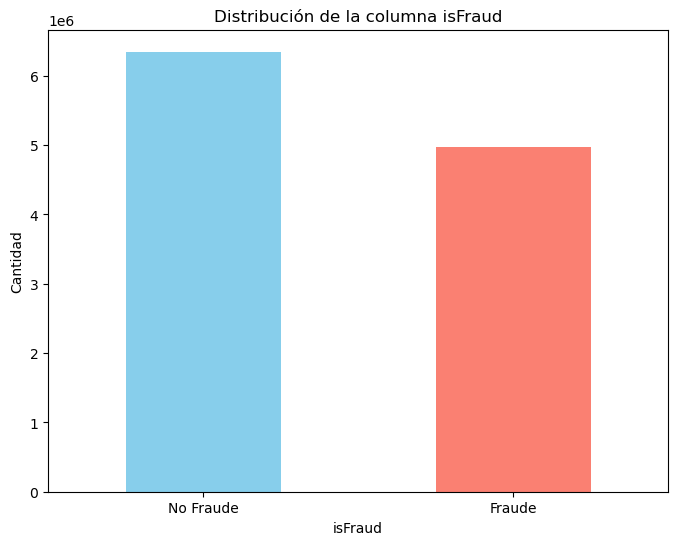

In [74]:
# Contar los valores de la columna isFraud
conteo_isfraud = df_banco['isFraud'].value_counts()

# Crear el gráfico de barras verticales
mpt.figure(figsize=(8, 6))
conteo_isfraud.plot(kind='bar', color=['skyblue', 'salmon'])
mpt.title('Distribución de la columna isFraud')
mpt.xlabel('isFraud')
mpt.ylabel('Cantidad')
mpt.xticks([0, 1], ['No Fraude', 'Fraude'], rotation=0)
mpt.show()

In [75]:
type(df_banco)

pandas.core.frame.DataFrame

#### Now, we´ll convert this pandas dataframe into a PySpark dataframe to leverage, but first to a parquet file.

In [76]:
df_banco.to_parquet('df.parquet')

In [77]:
df_bank_par = spark.read.parquet('df.parquet')

In [78]:
type(df_bank_par)

pyspark.sql.dataframe.DataFrame

In [79]:
df_bank_par.show(10)

+----+--------+------------+-------------+----------+------------+-------------+--------+--------+-------+
|step|  amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|
+----+--------+------------+-------------+----------+------------+-------------+--------+--------+-------+
|   1| 9839.64|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 1864.28|           0|            0|         0|           1|            0|       0|       1|      0|
|   1|   181.0|           0|            0|         0|           0|            1|       1|       0|      1|
|   1|   181.0|           0|            1|         0|           0|            0|       1|       0|      1|
|   1|11668.14|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 7817.71|           0|            0|         0|           1|            0|       0|       1|      0|
|   1| 7107.77|           0|         

In [80]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: long (nullable = true)



In [81]:
df_bank_par.count()

11316849

In [82]:
# convert string columns into integer columns

df_bank_par = df_bank_par.withColumn("isFraud",df_bank_par["isFraud"].cast(IntegerType()))

In [83]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [84]:
class_0 = df_bank_par.filter(f.col("isFraud")==0)
class_1 = df_bank_par.filter(f.col("isFraud")==1)

In [85]:
class_0.count()

6346920

In [86]:
class_1.count()

4969929

In [87]:
######################################## Convert parquet file into Pandas ##########################

##df_bank_par_pandas = df_bank_par.to_pandas_on_spark()
##df_bank_par_pandas.head(10)
##df_bank_par_pandas.describe()
##type(df_bank_par_pandas)

#### Let´s create a function to find a correlation between the target variable "isFraud" and the features. 

In [88]:
# definition of the function "correlation_df"

def correlation_df(df,target_var,feature_cols, method):
    # assemble features into a vector
    target_var = [target_var]
    feature_cols = feature_cols
    df_cor = df.select(target_var + feature_cols)
    assembler = VectorAssembler(inputCols=target_var + feature_cols, outputCol="features")
    df_cor = assembler.transform(df_cor)

    # calculate correlation matrix
    correlation_matrix = Correlation.corr(df_cor, "features", method =method).head()[0]

    # extract the correlation coefficient between target and each feature
    target_corr_list = [correlation_matrix[i,0] for i in range(len(feature_cols)+1)][1:]

    # create a Dataframe with target variable, feature names and correlation coefficients
    correlation_data = [(feature_cols[i],float(target_corr_list[i])) for i in range(len(feature_cols))]

    correlation_df = spark.createDataFrame(correlation_data, ["feature","correlation"] )

    correlation_df = correlation_df.withColumn("abs_correlation",f.abs("correlation"))

    # print the result
    return correlation_df

In [89]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [90]:
target = "isFraud"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()


24/05/28 12:54:11 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between isFraud and the other features is: 


+-------------+--------------------+-------------------+
|      feature|         correlation|    abs_correlation|
+-------------+--------------------+-------------------+
|         step| 0.34684009076918143|0.34684009076918143|
|       amount|  0.3604992933016074| 0.3604992933016074|
| type_CASH_IN| -0.3323385816575818| 0.3323385816575818|
|type_CASH_OUT|-0.10691980783674657|0.10691980783674657|
|   type_DEBIT|-0.05363819819216311|0.05363819819216311|
| type_PAYMENT| -0.4282609844322808| 0.4282609844322808|
|type_TRANSFER| 0.22944948951215355|0.22944948951215355|
|     type2_CC| 0.42826098443228067|0.42826098443228067|
|     type2_CM| -0.4282609844322808| 0.4282609844322808|
+-------------+--------------------+-------------------+



In [91]:
df_bank_par.printSchema()

root
 |-- step: long (nullable = true)
 |-- amount: double (nullable = true)
 |-- type_CASH_IN: long (nullable = true)
 |-- type_CASH_OUT: long (nullable = true)
 |-- type_DEBIT: long (nullable = true)
 |-- type_PAYMENT: long (nullable = true)
 |-- type_TRANSFER: long (nullable = true)
 |-- type2_CC: long (nullable = true)
 |-- type2_CM: long (nullable = true)
 |-- isFraud: integer (nullable = true)



In [92]:
target = "amount"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()


24/05/28 12:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:32 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between amount and the other features is: 
+-------------+--------------------+--------------------+
|      feature|         correlation|     abs_correlation|
+-------------+--------------------+--------------------+
|         step|  0.1242909520536949|  0.1242909520536949|
| type_CASH_IN| -0.1211462312604748|  0.1211462312604748|
|type_CASH_OUT|-0.04141203102129405| 0.04141203102129405|
|   type_DEBIT|-0.02682257141276...|0.026822571412764645|
| type_PAYMENT| -0.2114653262805776|  0.2114653262805776|
|type_TRANSFER| 0.15105593069727094| 0.15105593069727094|
|     type2_CC| 0.21146532628056097| 0.21146532628056097|
|     type2_CM| -0.2114653262805776|  0.2114653262805776|
|      isFraud|  0.3604992933016073|  0.3604992933016073|
+-------------+--------------------+--------------------+



In [93]:
target = "step"

indep_cols = [x for x in df_bank_par.columns if x not in [target] ]

corr_values_df = correlation_df(df=df_bank_par, target_var= target, feature_cols= indep_cols, method='pearson')

print(f"The corelation between {target} and the other features is: ")

corr_values_df.show()

24/05/28 12:54:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:54:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

The corelation between step and the other features is: 
+-------------+--------------------+--------------------+
|      feature|         correlation|     abs_correlation|
+-------------+--------------------+--------------------+
|       amount|  0.1242909520536949|  0.1242909520536949|
| type_CASH_IN|-0.11255059686687098| 0.11255059686687098|
|type_CASH_OUT|-0.04565434924107...|0.045654349241078744|
|   type_DEBIT|-0.01678650820881...|0.016786508208811435|
| type_PAYMENT|-0.14515981565813296| 0.14515981565813296|
|type_TRANSFER| 0.08329816241940949| 0.08329816241940949|
|     type2_CC|  0.1451598156581346|  0.1451598156581346|
|     type2_CM|-0.14515981565813296| 0.14515981565813296|
|      isFraud| 0.34684009076918176| 0.34684009076918176|
+-------------+--------------------+--------------------+



## 4. Construction of models

## 4.1 train/test split

In [474]:
train,test = df_bank_par.randomSplit([0.7,0.3])

#### Let´s assemble these datasets "train" and "test" into a single feature vector using VectorAssembler class per each one.

In [475]:
# let´s assemble the train dataset as a single feature vector using VectorAssembler class

columns = ['step','amount','type_CASH_OUT','type_PAYMENT','type_CASH_IN','type_TRANSFER','type_DEBIT','type2_CC','type2_CM','isFraud']

assembler = VectorAssembler(inputCols=columns, outputCol='features')

train = assembler.transform(train).withColumnRenamed("features", "my_features")

train.show(10)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|   1|  6.93|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 23.31|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 27.55|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 38.66|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],

In [476]:
# let´s assemble the test dataset as a single feature vector using VectorAssembler class

columns = ['step','amount','type_CASH_OUT','type_PAYMENT','type_CASH_IN','type_TRANSFER','type_DEBIT','type2_CC','type2_CM','isFraud']

assembler = VectorAssembler(inputCols=columns, outputCol='features')

test = assembler.transform(test).withColumnRenamed("features", "my_features")

test.show(10)

+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+
|   1|  6.42|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 15.06|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 25.12|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|
|   1| 53.35|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],

## 4.2 Models

We´ll use several machine learning algorithms to evaluate all of them and to select the best one. We´ll start with Random Forest. However, it´s important to create some lists where to store the results of the models:

In [477]:
name_model = []

accuracy = []

precision = []

recall = []

auc_roc = []

### 4.2.1 Random Forest

#### Training

In [248]:
# train the model "random forest" (rf)

modelRF = TrainValidationSplitModel.load("tuningRFProof")
print(modelRF.explainParams())

24/05/28 14:43:13 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 14:43:14 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


estimator: estimator to be cross-validated (current: Pipeline_48c78d62663a)
estimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_bb3413b295c6', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_bb3413b295c6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5}, {Param(parent='RandomForestClassifier_bb3413b295c6', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_bb3413b295c6', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 12}, {Param(parent='RandomForestClassifier_bb3413b295c6', name='numTrees', doc='Number of trees to train (>= 1).'): 10, Param(parent='RandomForestClassifier_bb3413b295c6', name='maxDepth', doc='Maximum dept

In [148]:
type(modelRF)

pyspark.ml.tuning.TrainValidationSplitModel

In [ ]:
modelRF.extractParamMap()

In [479]:
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="my_features")

In [480]:
modelRF = rf.fit(train)

24/05/29 00:15:44 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:15:45 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:15:45 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:15:45 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:15:45 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [481]:
predictions = modelRF.transform(test)

In [ ]:
# evaluation

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)


#### Hyperparameters tuning

In [430]:
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="my_features")

In [ ]:
print(rf.explainParams())

In [ ]:
# visualization of the overfitting

# define the tree depths to evaluate
values = [i for i in range(1, 11)]
train_scores = []
test_scores = []
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 rf = RandomForestClassifier(labelCol="isFraud", featuresCol="my_features", maxDepth=1, numTrees=i)
 # configure the evaluators and metrics
 evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
 metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")
 # fit model on the training dataset
 modelRF = rf.fit(train)
 # predictions on the training dataset
 predictions = modelRF.transform(train)
 # evaluate on the train dataset
 train_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 train_scores.append(train_accuracy)
 # evaluate on the test dataset
 predictions = modelRF.transform(test)
 test_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 test_scores.append(test_accuracy)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))

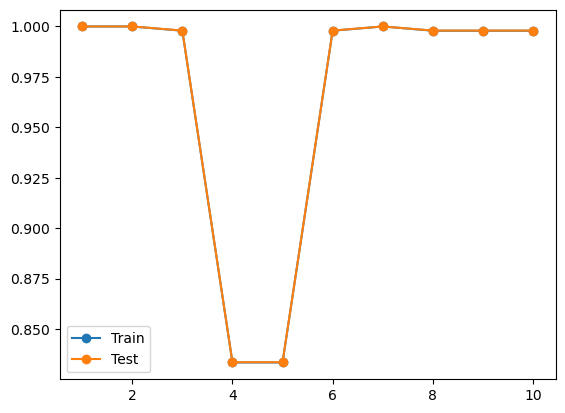

In [428]:
# plot of train and test scores vs tree depth

mpt.plot(values, train_scores, '-o', label='Train')
mpt.plot(values, test_scores, '-o', label='Test')
mpt.legend()
mpt.show()

In [458]:
# evaluate in the training dataset

predictions = modelRF.transform(train)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)

print(f"Precsion: ", precision_rf)

print(f"Recall: ", recall_rf)

# full the results list

auc_roc.append(auc_rf)

accuracy.append(accuracy_rf)

recall.append(recall_rf)

precision.append(precision_rf)

name_model.append("Random Forest")


24/05/28 23:58:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:58:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:58:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:58:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:58:05 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  0.998142848622413
Accuracy:  0.9979170379555241
Precsion:  0.9979268699252918
Recall:  0.997917037955524


In [ ]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)


######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()


In [482]:
# evaluate in the test dataset

predictions = modelRF.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)

print(f"Precsion: ", precision_rf)

print(f"Recall: ", recall_rf)

# full the results list

auc_roc.append(auc_rf)

accuracy.append(accuracy_rf)

recall.append(recall_rf)

precision.append(precision_rf)

name_model.append("Random Forest")


24/05/29 00:16:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:16:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:16:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:16:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:16:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  1.0
Accuracy:  1.0
Precsion:  1.0
Recall:  1.0


In [ ]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)


######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()


Now, we put our simple, two-stage workflow into an ML pipeline.

In [ ]:
# Cross Validation Model: feature importance 

bestPipeline = modelRF.bestModel
bestModel = bestPipeline.stages[1] # type: ignore

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

mpt.bar(x_values,importances, orientation='vertical')
mpt.xticks(x_values, columns, rotation = 40)
mpt.ylabel('Importance')
mpt.xlabel('Feature')
mpt.title('Feature Importances')


### Predictions

In [101]:
# predictions of the model

predictions = modelRF.transform(test)

print('The predictions of the model are:')

predictions.show(10)

The predictions of the model are:


+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|step|amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|            features|       rawPrediction|         probability|prediction|
+----+------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+--------------------+----------+
|   1|  8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|          [10.0,0.0]|           [1.0,0.0]|       0.0|
|   1| 13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|          [10.0,0.0]|           [1.0,0.0]|       0.0|


#### We can see that there are three more columns: rawPrediction, probability and prediction.

### Evaluation

#### Let´s check out the Consufion Matrix.

In [ ]:
modelRF = rf.fit(train)
predictions = modelRF.transform(test)

preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

### 4.2.2 Logistic Regression

#### Training

In [108]:
# train the model "logistic regression" (lr)

modelLR = CrossValidatorModel.load("tuningLRProof")
print(modelLR.explainParams())

estimator: estimator to be cross-validated (current: Pipeline_f013f093b062)
estimatorParamMaps: estimator param maps (current: [{Param(parent='LogisticRegression_7f5f784bc54e', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_7f5f784bc54e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_7f5f784bc54e', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_7f5f784bc54e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}, {Param(parent='LogisticRegression_7f5f784bc54e', name='regParam', doc='regularization parameter (>= 0).'): 0.0, Param(parent='LogisticRegression_7f5f784bc54e', name='elasticNetParam', doc='the ElasticNet mixing par

In [ ]:
type(modelLR)

In [ ]:
modelLR.extractParamMap()

In [483]:
lr = LogisticRegression(featuresCol="my_features", labelCol="isFraud")

In [ ]:
print(lr.explainParams())

In [484]:
modelLR = lr.fit(train)

predictions = modelLR.transform(test)

24/05/29 00:17:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:17:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:17:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:17:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:17:30 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

KeyboardInterrupt: 

24/05/29 00:18:28 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:28 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:30 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:30 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:32 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:32 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 17.0 MiB so far)


In [ ]:
# evaluation

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)


#### Hyperparameters tuning

In [ ]:
# visualization of the overfitting

# define the tree depths to evaluate
values = [i for i in range(1, 11)]
train_scores = []
test_scores = []
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 lr = LogisticRegression(labelCol="isFraud", featuresCol="my_features")
 # configure the evaluators and metrics
 evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
 metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")
 # fit model on the training dataset
 modelLR = lr.fit(train)
 # predictions on the training dataset
 predictions = modelLR.transform(train)
 # evaluate on the train dataset
 train_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 train_scores.append(train_accuracy)
 # evaluate on the test dataset
 predictions = modelLR.transform(test)
 test_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 test_scores.append(test_accuracy)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))

In [ ]:
# plot of train and test scores vs tree depth

mpt.plot(values, train_scores, '-o', label='Train')
mpt.plot(values, test_scores, '-o', label='Test')
mpt.legend()
mpt.show()

In [460]:
# evaluate in the training dataset

predictions = modelLR.transform(train)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)

print(f"Precsion: ", precision_rf)

print(f"Recall: ", recall_rf)

# full the results list

auc_roc.append(auc_rf)

accuracy.append(accuracy_rf)

recall.append(recall_rf)

precision.append(precision_rf)

name_model.append("Logistic Regression")


24/05/28 23:59:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:59:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:59:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:59:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:59:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

KeyboardInterrupt: 

In [ ]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)


######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

In [ ]:
# evaluate in the test dataset

predictions = modelLR.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_rf = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)

print(f"Precsion: ", precision_rf)

print(f"Recall: ", recall_rf)

# full the results list

auc_roc.append(auc_rf)

accuracy.append(accuracy_rf)

recall.append(recall_rf)

precision.append(precision_rf)

name_model.append("Logistic Regression")



24/05/29 00:06:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:06:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:06:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:06:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:06:53 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  0.6544181140502122
Accuracy:  0.6731756097604094
Precsion:  0.6728923793706951
Recall:  0.6731756097604094


The graphic ROC curve is:


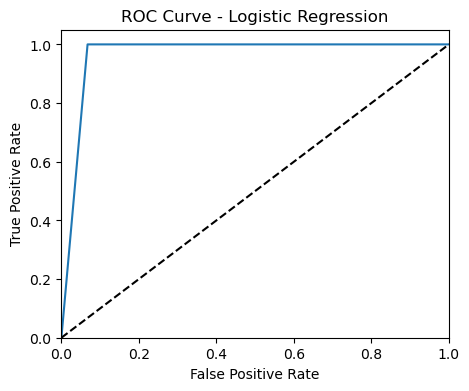

In [414]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)


######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()


In [415]:
# confusion matrix

predictions = modelLR.transform(test)

preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/28 20:11:11 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


The Confusion Matrix is:


24/05/28 20:11:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 20:11:12 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1775824.,  128545.],
       [      0., 1491844.]])

In [113]:
# coefficients and intercept

##print('The coefficients are:', modelLR.coefficients)
##print('The independent term is:', modelLR.intercept)

In [114]:
# model summary

##model_LR = CrossValidatorModel.load("tuningLRProof")
##summary_lr = model_LR.bestModel

##print('The area under ROC:',summary_lr)
##print('The ROC is:',summary_lr.roc.show())
##print('pr is',summary_lr.pr.show())

In [115]:
##summary_lr.objectiveHistory

#### Predictions

In [116]:
# make predictions of the logistic regression model using the test dataset

predictions.select('isfraud','prediction','probability').show(10)

+-------+----------+--------------------+
|isfraud|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      0|       0.0|[0.99999999937023...|
|      1|       1.0|[2.14856365377640...|
|      0|       0.0|[0.99999999835633...|
+-------+----------+--------------------+
only showing top 10 rows



### Evaluation

#### Let´s check out the Confusion Matrix.

In [121]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/28 12:57:16 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


The Confusion Matrix is:


24/05/28 12:57:16 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 12:57:16 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1905170.,       0.],
       [      0., 1491456.]])

### 4.2.3 Decision Tree

#### Training

In [122]:
# train the model Decision Tree (dt)

modelDT = CrossValidatorModel.load("tuningDTProof")

In [123]:
type(modelDT)

pyspark.ml.tuning.CrossValidatorModel

In [ ]:
dt = DecisionTreeClassifier(featuresCol="my_features", labelCol="isFraud")

In [ ]:
modelDT = dt.fit(train)

predictions = modelDT.transform(test)

In [ ]:
# evaluation

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)


#### Hyperparameters tuning

In [ ]:
# visualization of the overfitting


# define the tree depths to evaluate
values = [i for i in range(0, 6)]
train_scores = []
test_scores = []
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 dt = DecisionTreeClassifier(featuresCol="my_features",labelCol="isFraud",maxDepth=i)
 # configure the evaluators and metrics
 evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
 metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")
 # fit model on the training dataset
 modelDT = dt.fit(train)
 # predictions on the training dataset
 predictions = modelDT.transform(train)
 # evaluate on the train dataset
 train_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 train_scores.append(train_accuracy)
 # evaluate on the test dataset
 predictions = modelDT.transform(test)
 test_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 test_scores.append(test_accuracy)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))


# plot of train and test scores vs tree depth
mpt.plot(values, train_scores, '-o', label='Train')
mpt.plot(values, test_scores, '-o', label='Test')
mpt.legend()
mpt.show()

In [ ]:
# evaluate in the training dataset

predictions = modelDT.transform(train)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_dt = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_dt = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_dt)

print(f"Accuracy: ", accuracy_dt)

print(f"Precsion: ", precision_dt)

print(f"Recall: ", recall_dt)

# full the results list

auc_roc.append(auc_dt)

accuracy.append(accuracy_dt)

recall.append(recall_dt)

precision.append(precision_dt)

name_model.append("Decision Tree")


In [ ]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)

######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

In [ ]:
# evaluate in the test dataset

predictions = modelDT.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_dt = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_dt)

print(f"Precsion: ", precision_dt)

print(f"Recall: ", recall_dt)

# full the results list

auc_roc.append(auc_rf)

accuracy.append(accuracy_rf)

recall.append(recall_rf)

precision.append(precision_rf)

name_model.append("Decision Tree")



24/05/29 00:07:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:07:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:07:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:07:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:07:26 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  1.0
Accuracy:  1.0
Precsion:  1.0
Recall:  1.0


In [ ]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)

######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

#### Predictions

In [124]:
# make predictions of the decision tree model using the test dataset

predictions = modelDT.transform(test)

predictions.show(50)

+----+-------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+---------------+-----------+----------+
|step| amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|            features|  rawPrediction|probability|prediction|
+----+-------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+---------------+-----------+----------+
|   1|   8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|[4441828.0,0.0]|  [1.0,0.0]|       0.0|
|   1|  13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|[4441828.0,0.0]|  [1.0,0.0]|       0.0|
|   1|  23.31|           0|            0|         0|           1|

### Evaluation

#### Let´s check out the Confusion Matrix.

In [ ]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

### 4.2.4 Naive Bayes

#### Training

In [130]:
# train the model Naive Bayes (nb)

modelNB = CrossValidatorModel.load("tuningNBProof")

In [131]:
type(modelNB)

pyspark.ml.tuning.CrossValidatorModel

In [485]:
nb = NaiveBayes(featuresCol="my_features", labelCol="isFraud")

modelNB = nb.fit(train)

predictions = modelNB.transform(test)


24/05/29 00:18:34 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:34 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 17.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_2 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_5 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_8 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_3 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:44 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 65.0 MiB so far)
24/05/29 00:18:46 WARN MemoryStore: Not enough space to cache rdd_8026_5 in memory! (computed 33.0 MiB so far)
2

24/05/29 00:18:48 WARN MemoryStore: Not enough space to cache rdd_8026_5 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:48 WARN MemoryStore: Not enough space to cache rdd_8026_1 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:48 WARN MemoryStore: Not enough space to cache rdd_8026_8 in memory! (computed 33.0 MiB so far)
24/05/29 00:18:48 WARN MemoryStore: Not enough space to cache rdd_8026_7 in memory! (computed 33.0 MiB so far)


In [440]:
print(nb.explainParams())

featuresCol: features column name. (default: features, current: my_features)
labelCol: label column name. (default: label, current: isFraud)
modelType: The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian. (default: multinomial)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: probability)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)
smoothing: The smoothing parameter, should be >= 0, default is 1.0 (default: 1.0)
thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class. Array must have length equal to the number of classes, with values > 0, excepting that at most one value may be 0. The clas

In [ ]:
# evaluation

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_rf = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_rf = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

print(f"AUC-ROC: ", auc_rf)

print(f"Accuracy: ", accuracy_rf)


#### Hyperparameters tuning

In [ ]:
# visualization of the overfitting

# define the tree depths to evaluate
values = [i for i in range(0, 6)]
train_scores = []
test_scores = []
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 lr = NaiveBayes(labelCol="isFraud", featuresCol="my_features", smoothing=i)
 # configure the evaluators and metrics
 evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")
 metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")
 # fit model on the training dataset
 modelLR = lr.fit(train)
 # predictions on the training dataset
 predictions = modelLR.transform(train)
 # evaluate on the train dataset
 train_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 train_scores.append(train_accuracy)
 # evaluate on the test dataset
 predictions = modelLR.transform(test)
 test_accuracy = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})
 test_scores.append(test_accuracy)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_accuracy, test_accuracy))

 # plot of train and test scores vs tree depth

mpt.plot(values, train_scores, '-o', label='Train')
mpt.plot(values, test_scores, '-o', label='Test')
mpt.legend()
mpt.show()

In [442]:
# evaluate in the training dataset

predictions = modelDT.transform(train)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_dt = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_dt = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_dt)

print(f"Accuracy: ", accuracy_dt)

print(f"Precsion: ", precision_dt)

print(f"Recall: ", recall_dt)

# full the results list

auc_roc.append(auc_dt)

accuracy.append(accuracy_dt)

recall.append(recall_dt)

precision.append(precision_dt)

name_model.append("Naive Bayes")



24/05/28 23:37:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:37:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:37:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:37:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:37:49 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  1.0
Accuracy:  1.0
Precsion:  1.0
Recall:  1.0


The graphic ROC curve is:


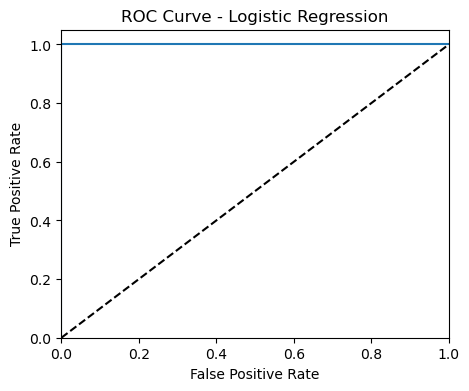

In [443]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)

######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()


In [486]:
# evaluate in the test dataset

predictions = modelNB.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="isFraud")

auc_dt = evaluator.evaluate(predictions)

# Accuracy, Precision and Recall

metrics = MulticlassClassificationEvaluator(predictionCol="prediction",labelCol="isFraud")

accuracy_dt = metrics.evaluate(predictions, {metrics.metricName:"accuracy"})

precision_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedPrecision"})

recall_dt = metrics.evaluate(predictions, {metrics.metricName:"weightedRecall"})

print(f"AUC-ROC: ", auc_dt)

print(f"Accuracy: ", accuracy_dt)

print(f"Precsion: ", precision_dt)

print(f"Recall: ", recall_dt)

# full the results list

auc_roc.append(auc_dt)

accuracy.append(accuracy_dt)

recall.append(recall_dt)

precision.append(precision_dt)

name_model.append("Naive Bayes")



24/05/29 00:18:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:18:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:18:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:18:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 00:18:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

AUC-ROC:  0.6549852118719726
Accuracy:  0.6737159738328996
Precsion:  0.6734698164401426
Recall:  0.6737159738328995


The graphic ROC curve is:


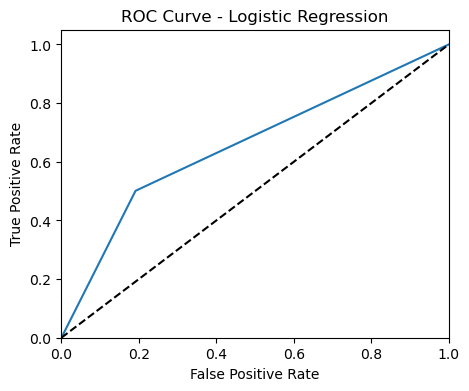

In [445]:
########################### ROC graphic ###########################

preds_and_labels = predictions.select("prediction", "isFraud")
preds_and_labels_collect = preds_and_labels.collect()

#preds_and_labels_list = [ (float(i[0][0]), 1.0 - float(i[1])) for i in preds_and_labels_collect  ]
#preds_and_labels = sc.parallelize(preds_and_labels_list)

#metrics = BinaryClassificationMetrics(preds_and_labels)

######################### Visualization ###########################

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test = [i[1] for i in preds_and_labels_collect]
y_score = [i[0] for i in preds_and_labels_collect]

fpr, tpr, _ = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

print("The graphic ROC curve is:")

mpt.figure(figsize=(5,4))
mpt.plot(fpr, tpr, label='ROC curve' % roc_auc)
mpt.plot([0,1],[0,1],'k--')
mpt.xlim([0.0,1.0])
mpt.ylim([0.0,1.05])
mpt.xlabel('False Positive Rate')
mpt.ylabel('True Positive Rate')
mpt.title('ROC Curve - Logistic Regression')
mpt.show()

#### Predictions

In [135]:
# make predictions of the naive bayes model using the test dataset

predictions = modelNB.transform(test)

predictions.show(50)

+----+-------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+-----------+----------+
|step| amount|type_CASH_IN|type_CASH_OUT|type_DEBIT|type_PAYMENT|type_TRANSFER|type2_CC|type2_CM|isFraud|         my_features|            features|       rawPrediction|probability|prediction|
+----+-------+------------+-------------+----------+------------+-------------+--------+--------+-------+--------------------+--------------------+--------------------+-----------+----------+
|   1|   8.73|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|[-33.461561721126...|  [1.0,0.0]|       0.0|
|   1|  13.54|           0|            0|         0|           1|            0|       0|       1|      0|(10,[0,1,3,8],[1....|(10,[0,1,3,8],[1....|[-33.468347416645...|  [1.0,0.0]|       0.0|
|   1|  23.31|           0|            0

24/05/28 12:58:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


#### Evaluation

#### Let´s check out the Confusion Matrix.

In [446]:
preds_and_labels = predictions.select(["prediction","isFraud"])
preds_and_labels = preds_and_labels.withColumn("isFraud", f.col("isFraud").cast(FloatType())).orderBy("prediction")

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print("The Confusion Matrix is:")

metrics.confusionMatrix().toArray()

/opt/anaconda3/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/05/28 23:43:50 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


The Confusion Matrix is:


24/05/28 23:43:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/28 23:43:51 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


array([[1539968.,  364401.],
       [ 744605.,  747239.]])

## 4.3 Evaluation and Selection of the model

We´ll evaluate the models using the metrics used in the previous step and we´ll select the model with the best performance. As first step, let´s create a dictionary with the results of every model.

In [487]:
results = {
    'Name_Model': name_model,
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'AUC_ROC':auc_roc
}

In [488]:
results

{'Name_Model': ['Random Forest', 'Naive Bayes'],
 'Accuracy': [1.0, 0.6737159738328996],
 'Precision': [1.0, 0.6734698164401426],
 'Recall': [1.0, 0.6737159738328995],
 'AUC_ROC': [1.0, 0.6549852118719726]}

#### Now, let´s create a pandas dataframe with the results dictionary.

In [489]:
results_df = pd.DataFrame(results)
results_df.set_index('Name_Model', inplace=True)
#results_df.set_index("Name_Model", inplace=True)

In [490]:
results_df.head(5)

,Accuracy,Precision,Recall,AUC_ROC
Name_Model,,,,
Random Forest,1.000000,1.00000,1.000000,1.000000
Naive Bayes,0.673716,0.67347,0.673716,0.654985


In [471]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Random Forest to Naive Bayes
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Accuracy   4 non-null      float64
 1   Precision  4 non-null      float64
 2   Recall     4 non-null      float64
 3   AUC_ROC    4 non-null      float64
dtypes: float64(4)
memory usage: 160.0+ bytes


#### Let´s visualize these results.

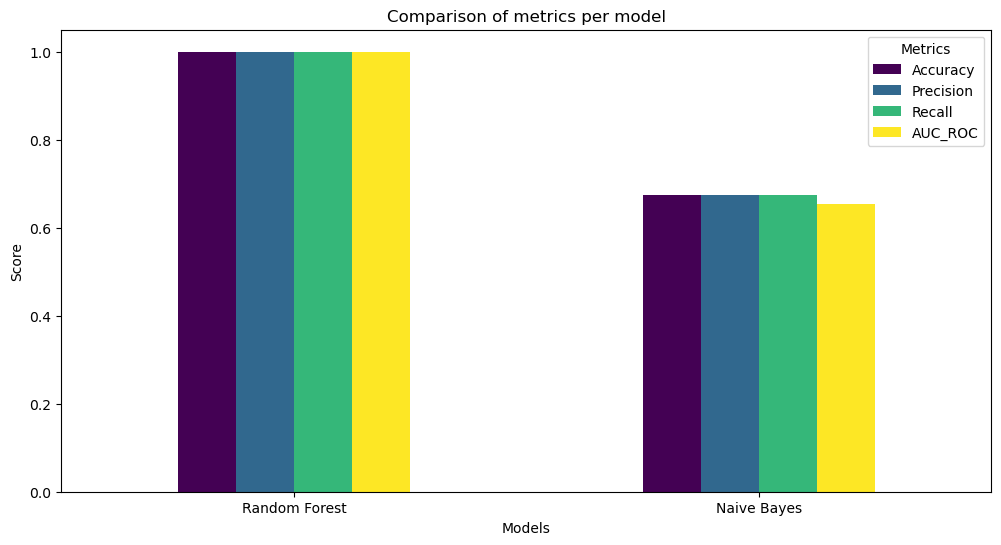

""


In [491]:
# "results_df" dataframe

colors = ['#0077b6','#CDDBF3','#9370DB','#DDA0DD']
results_df.plot(kind='bar', figsize=(12,6), colormap='viridis', rot=0)
mpt.title('Comparison of metrics per model')
mpt.xlabel('Models')
mpt.ylabel('Score')
mpt.legend(title = 'Metrics')
mpt.tight_layout
mpt.show()

pd.DataFrame()

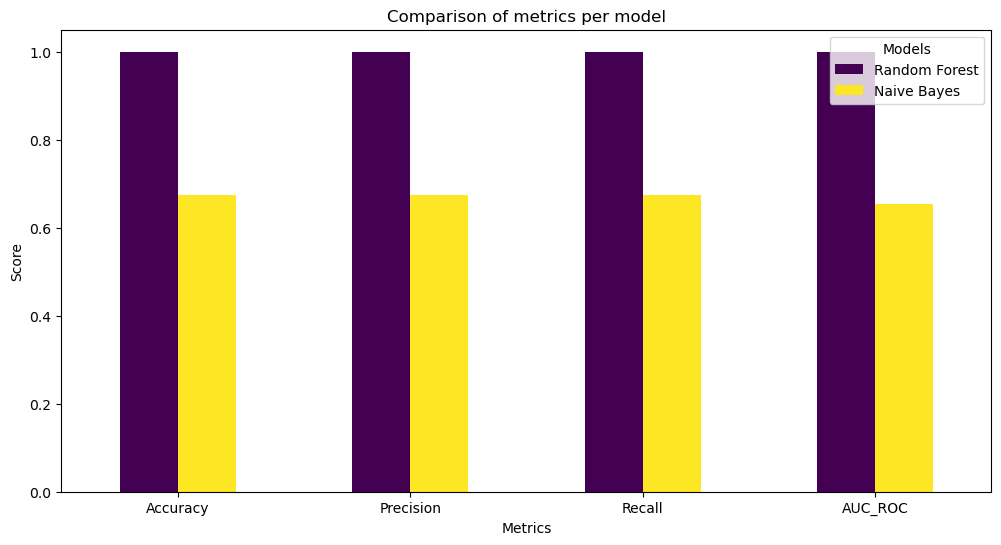

In [492]:
# transpose of the "results_df" dataframe

results_df = results_df.T
colors = ['#0077b6','#CDDBF3','#9370DB','#DDA0DD']
results_df.plot(kind='bar', figsize=(12,6), colormap='viridis', rot=0)
mpt.title('Comparison of metrics per model')
mpt.xlabel('Metrics')
mpt.ylabel('Score')
mpt.legend(title = 'Models')
mpt.tight_layout
mpt.show()


## 5. Storage

### 5.1 Model

In [146]:
# model: Random Forest

modelRF.save("modelRF")

# model: Logistic Regression

modelLR.save("modelLR")

# model: Decision Tree

modelDT.save("modelDT")

# model: Naive Bayes

modelNB.save("modelNB")


Py4JJavaError: An error occurred while calling o3257.save.
: java.io.IOException: Path modelRF already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


### 5.2 Load

In [ ]:
# model: Random Forest

loaded_model_RF =  RandomForestClassificationModel().load("modelRF")


# model: Logistic Regression

loaded_model_LR = LogisticRegression.load("modelLR")

# model: Decision Tree

loaded_model_LR = DecisionTreeClassifier.load("modelDT")

# model: Naive Bayes

loaded_model_LR = NaiveBayes.load("modelNB")